In [5]:
%matplotlib widget
# %matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# import os
import sys
sys.path.insert(0, '..')
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from Xana import Xana
from Xana import Soq
from Xana.XpcsAna import CorrFunc as G2
# from functions.slurm import submit_job
# import time
import pickle
from glob import glob
# import seaborn as sns
# import pandas as pd
# import h5py as h5
# import lmfit
import re
from lmfit.models import LinearModel
from pathlib import Path
#plt.style.use('../nbstyle.mplstyle')

In [7]:
datadir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/'
anadir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed'

# Analysis database

In [8]:
datafolder = 'ferritin_conc_gly_50_6'
datasetnumber = 4 # 230 K

In [9]:
ana_db_files = glob(f'{anadir}/results/{datafolder}_{datasetnumber:04d}/p*/analysis_database.pkl')
ana_db_files

['/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc_gly_50_6_0004/p324127/analysis_database.pkl',
 '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc_gly_50_6_0004/p324126/analysis_database.pkl',
 '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc_gly_50_6_0004/p324131/analysis_database.pkl',
 '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc_gly_50_6_0004/p324173/analysis_database.pkl']

In [10]:
d = Xana(fmtstr='ebs_id10_eiger500k', detector='eiger500k', 
            setupfile=f'{anadir}/mask-setup/setup-fullmask-cryo-230417.pkl',
            maskfile='../setups/cryo-mask-230417_03.npy'
           )

for i, f in enumerate(ana_db_files):
    if i == 0:
        d.load_db(f)
    else:
        d.append_db(f)

Loaded setupfile:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/mask-setup/setup-fullmask-cryo-230417.pkl.
Try loading database:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc_gly_50_6_0004/p324127/analysis_database.pkl
Successfully loaded database


In [11]:
len(d.db)

704

# SAXS

In [12]:
d.db['datdir'].loc[0]

PosixPath('/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferritin_conc_gly_50_6/ferritin_conc_gly_50_6_0004/scan0001')

In [13]:
# to add a column to the db with the scan number in order to select the runs from the same measurement
def get_datdir_number(s):
    s = str(s)
    # s = re.search(r"(?<=conc100_gly_50_1_)\d{4}", s)
    s = re.search(r"(?<=gly_50_6_)\d{4}", s)
    #ferritin_conc_gly50_
    if s is not None:
        return int(s.group(0))
    else:
        return
    
# add column
d.db['subdir_n'] = d.db['datdir'].apply(get_datdir_number)
# d.db['scan_n'] = d.db['datdir'].apply(get_scan_number)

In [14]:
def get_scan_number(s):
    s = str(s)
    s = re.search('(?<=scan)\d{4}', s)
    if s is not None:
        return int(s.group(0))
    else:
        return -1
    
def get_rep(x, reps_per_spot=4):
    scan = get_scan_number(x)
    return (scan % reps_per_spot) + 1

In [15]:
d.db['rep'] = d.db['master'].apply(get_rep)

In [18]:
len(d.db[(d.db['analysis'] == 'saxs')].index.values)

352

In [16]:
rep = 1
ind_saxs = d.db[(d.db['analysis'] == 'saxs')
               & (d.db['rep'] == rep)
                ].index.values
ind_xpcs = d.db[(d.db['analysis'] == 'xpcs')
                & (d.db['rep'] == rep)].index.values
print(f"number of saxs analysis: {len(ind_saxs)}")
print(f"number of xpcs analysis: {len(ind_xpcs)}")
# display(d.db.loc[ind_saxs])
d.db.loc[ind_xpcs]

number of saxs analysis: 88
number of xpcs analysis: 88


,use,sample,analysis,mod,savname,savfile,setupfile,comment,series,t_exposure,t_readout,nframes,master,first,last,datdir,subdir_n,rep
7,True,,xpcs,2023-04-18 11:11:41.500380,s0004_0007.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,4.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,4,1
15,True,,xpcs,2023-04-18 11:22:46.588076,s0008_0015.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,8.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,4,1
23,True,,xpcs,2023-04-18 11:33:46.084793,s0012_0023.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,12.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,4,1
31,True,,xpcs,2023-04-18 11:44:46.534365,s0016_0031.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,16.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,4,1
39,True,,xpcs,2023-04-18 11:55:50.532717,s0020_0039.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,20.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,True,,xpcs,2023-04-18 17:51:32.727675,s0224_0127.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,224.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,6,1
679,True,,xpcs,2023-04-18 18:02:47.266173,s0228_0135.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,228.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,6,1
687,True,,xpcs,2023-04-18 18:14:04.375265,s0232_0143.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,232.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,6,1
695,True,,xpcs,2023-04-18 18:25:18.716977,s0236_0151.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,236.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,6,1


In [136]:
s = Soq(d)

In [137]:
tmp = d.get_item(ind_saxs[0])
tmp.keys()

dict_keys(['Isaxs', 'Vsaxs', 'soq'])

/tmp/ipykernel_25878/2578249205.py:11: RuntimeWarning: divide by zero encountered in log
  im2 = a2.imshow(np.log(image), vmin=-8, vmax=-1)


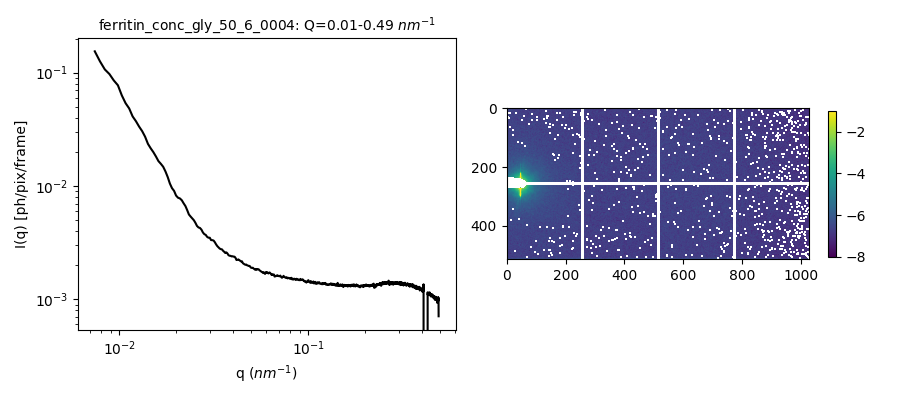

In [138]:
tmp = d.get_item(ind_saxs[1])
soq = tmp['soq']
image = tmp['Isaxs']
# print(image.shape)
f,(a1,a2) = plt.subplots(1,2,figsize=(9,4), tight_layout=True)
# f, a2 = plt.subplots(1,1,figsize=(7,6), tight_layout=True)
# col = plt.cm.viridis(np.linspace(0,1,len(ind)))
a1.plot(soq[:,0], soq[:,1], '-k')
# image[mask==0] = np.nan
# image[mask2==0] = np.nan
im2 = a2.imshow(np.log(image), vmin=-8, vmax=-1)
plt.colorbar(im2, ax=a2, shrink=0.5)

a1.set_title(f'{datafolder}_{datasetnumber:04d}: Q={soq[0,0]:.2f}-{soq[-1,0]:.2f} $nm^{{-1}}$', fontsize=10)
a1.set_xscale('log')
a1.set_yscale('log')
a1.set_xlabel('q ($nm^{-1}$)')
a1.set_ylabel('I(q) [ph/pix/frame]')
plt.show()

### Average over all scans

In [139]:
Iqs = []
qs = d.get_item(ind_saxs[0])['soq'][:,0]
for ind in ind_saxs:
    Iqs.append(d.get_item(ind)['soq'][:,1])
Iq_avg =  np.average(Iqs, axis=0)
Iq_avg_per_spot = np.average(Iqs, axis=1)
print(np.shape(Iqs), np.shape(Iq_avg))

(88, 1000) (1000,)


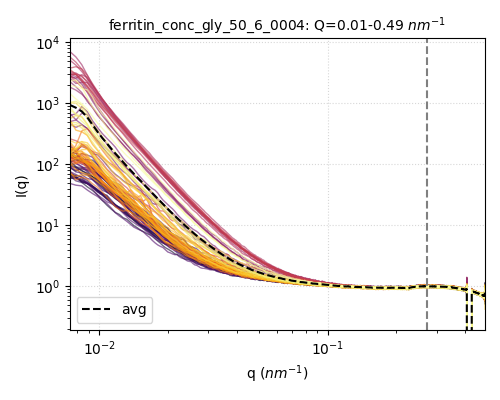

In [140]:
f, a1 = plt.subplots(1,1, tight_layout=True, figsize=(5,4))
col = plt.cm.inferno(np.linspace(0,1,len(ind_saxs)))
q_sel = 550

for i in range(len(Iqs)):
    a1.plot(qs, Iqs[i]/Iqs[i][q_sel], c=col[i], lw=1, alpha=0.6) # norm
    # a1.plot(qs, Iqs[i], c=col[i], lw=1, alpha=0.6) 

a1.plot(qs, Iq_avg/Iq_avg[q_sel], '--k', label='avg') # norm
a1.axvline(qs[q_sel], c='gray', ls='--')
# a1.plot(qs, Iq_avg, '--k', label='avg')

a1.set_xlim(qs[0],qs[-1])
a1.set_title(f'{datafolder}_{datasetnumber:04d}: Q={soq[0,0]:.2f}-{soq[-1,0]:.2f} $nm^{{-1}}$', fontsize=10)
a1.set_xscale('log')
a1.set_yscale('log')
a1.set_xlabel('q ($nm^{-1}$)')
a1.set_ylabel('I(q)')
a1.grid(ls=':', alpha=.5)
a1.legend()
plt.show()

/tmp/ipykernel_25878/376631572.py:6: RuntimeWarning: invalid value encountered in divide
  a1.plot(qs, Iqs[i]/Iqs[0], c=col[i], lw=1, alpha=0.6)
/tmp/ipykernel_25878/376631572.py:8: RuntimeWarning: invalid value encountered in divide
  a1.plot(qs, Iq_avg/Iqs[0], '--k', label='avg')


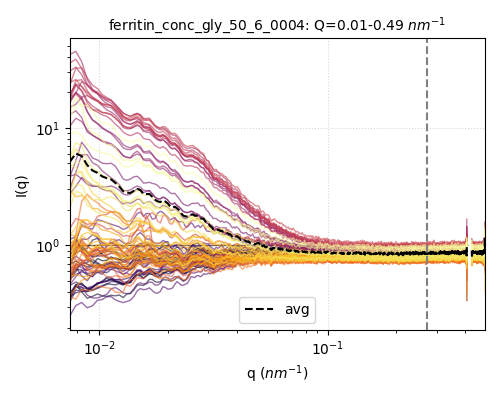

In [141]:
f, a1 = plt.subplots(1,1, tight_layout=True, figsize=(5,4))
col = plt.cm.inferno(np.linspace(0,1,len(ind_saxs)))
q_sel = 550

for i in range(len(Iqs)):
    a1.plot(qs, Iqs[i]/Iqs[0], c=col[i], lw=1, alpha=0.6)

a1.plot(qs, Iq_avg/Iqs[0], '--k', label='avg')
a1.axvline(qs[q_sel], c='gray', ls='--')

a1.set_xlim(qs[0],qs[-1])
a1.set_title(f'{datafolder}_{datasetnumber:04d}: Q={soq[0,0]:.2f}-{soq[-1,0]:.2f} $nm^{{-1}}$', fontsize=10)
a1.set_xscale('log')
a1.set_yscale('log')
a1.set_xlabel('q ($nm^{-1}$)')
a1.set_ylabel('I(q)')
a1.grid(ls=':', alpha=.5)
a1.legend()
plt.show()

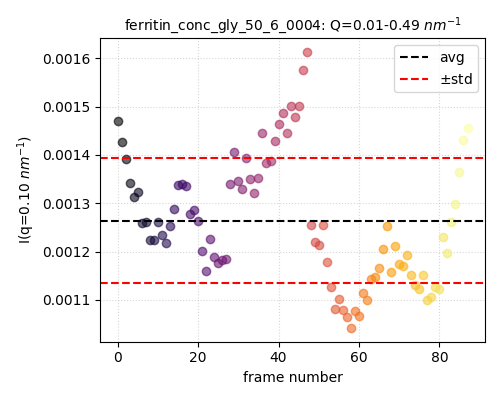

In [142]:
f, a1 = plt.subplots(1,1, tight_layout=True, figsize=(5,4))
col = plt.cm.inferno(np.linspace(0,1,len(ind_saxs)))

q_sel = 200
Iq_avg_qsel = []

for i in range(len(Iqs)):
    Iq_avg_qsel.append(Iqs[i][q_sel])
    a1.plot(i, Iqs[i][q_sel], c=col[i], ls='', alpha=0.6, marker='o')
a1.axhline(y=np.average(Iq_avg_qsel), ls='--', c='k', label='avg')
a1.axhline(y=np.average(Iq_avg_qsel)+np.std(Iq_avg_qsel), ls='--', c='r', label='$\pm$std')
a1.axhline(y=np.average(Iq_avg_qsel)-np.std(Iq_avg_qsel), ls='--', c='r')

# a1.set_xlim(qs[0],qs[-1])
a1.set_title(f'{datafolder}_{datasetnumber:04d}: Q={soq[0,0]:.2f}-{soq[-1,0]:.2f} $nm^{{-1}}$', fontsize=10)
# a1.set_xscale('log')
# a1.set_yscale('log')
a1.set_xlabel('frame number')
a1.set_ylabel(f'I(q={qs[q_sel]:.2f} $nm^{{-1}}$)')
a1.grid(ls=':', alpha=.5)
a1.legend()
plt.show()

# XPCS

**Sort based on the trace**

In [56]:
valid = [True]*len(ind_xpcs)

In [57]:
traces = []
for index in ind_xpcs:
    traces.append(d.get_item(index)['trace'][:,1].mean())
traces = np.array(traces)

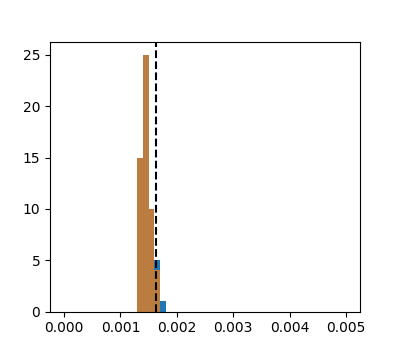

In [58]:
# sort based on the intensity
nsigma = 2
valid = traces < traces.mean() + nsigma*traces.std() #1#0.02#0255
plt.figure(figsize=(4,3.5))
plt.hist(traces, range=(0,.005), bins=50, facecolor='C0', alpha=1)
plt.axvline(x=traces.mean() + nsigma*traces.std() , ls='--', c='k')
plt.hist(traces[valid], range=(0,.005), bins=50, facecolor='C1', alpha=0.7)
plt.show()

In [91]:
ind_xpcs_valid = ind_xpcs[valid]
print(np.shape(ind_xpcs_valid), np.shape(ind_xpcs), np.shape(valid))

(16,) (16,) (16,)


In [92]:
g = G2(d)
g.get_g2(ind_xpcs_valid, merge='merge')

Merged g2 functions:  [0.0002] (exposure times)
                      [16] (number of correlation functions)
                      [79840] (total number of images)


In [96]:
g.reset_rescaled()
g.rescale(interval=(1, -10))

Fit successful: True


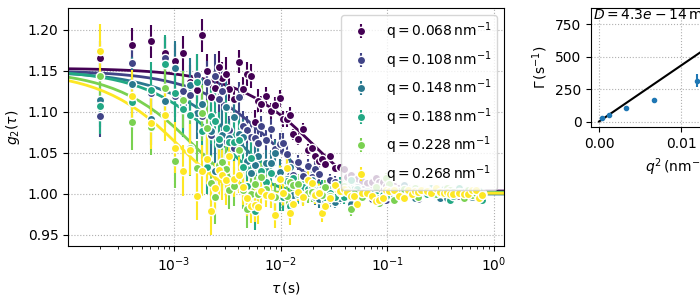

In [98]:
fig, ax = plt.subplots(figsize=(7,3), constrained_layout=True)

g.plot_g2(nq=np.arange(1,7), dofit=1, doplot='data_fit_legq',
           fix={'beta': 0.15, 'g0': 1},
           init={'t0': (3e-3, 0, 1),
                 'a': (.7, 0, 3),
            #      'g0': (1, 0, 2),
                 #'beta': (.06, 0, 1)
                }, 
      #      fitglobal=['a'], 
           cmap='viridis',ax=ax)
ax.grid(ls=':')
#ax.set_ylim(.9, 2.5)

inset = ax.inset_axes([1.2, .5, .4, .5])
p = g.pars[0]
x = p['q']**3
y = 1/p['t0']
dy = yerr=1/p['t0']**2*p['dt0']
inset.errorbar(x, y, yerr=dy, fmt='.')
inset.set_xlabel(r"$q^2\,(\mathrm{nm^{-1}})$")
inset.set_ylabel(r"$\Gamma\,(\mathrm{s^{-1}})$")

model = LinearModel()
pars = model.make_params()
pars['intercept'].set(0, vary=False)
res = model.fit(y, pars, x=x, weights=1/dy)
xf = np.linspace(0, x.max(), 100)
yf = model.eval(res.params, x=xf)
inset.plot(xf, yf, 'k')
inset.grid(ls=':')
D = res.params['slope'].value * 1e-18
dD = res.params['slope'].stderr * 1e-18

#txt = f"$D = {D:.1e} ± {dD:.0e}\,\mathrm{{m\,s^{{-1}}}}$"
txt = f"$D = {D:.1e}\,\mathrm{{m\,s^{{-1}}}}$"
inset.text(.01,.9, txt, color='k', transform=inset.transAxes);

In [ ]:
plt.figure(figsize=(4,3.5), tight_layout=True)
qv = 2
col = plt.cm.coolwarm_r(np.linspace(0,1,len(g2s)))

for i in range(len(T)):
    g = g2s[str(T[i])]
    
    g2 = np.array(g.corrFunc)
    g2_sort = g2[:,0,:,1:]
    g2_err = g2[:,1,:,1:]
    time = g2[0,0,:,0]
    
    y = (g2_sort[0,:-2,qv] - np.average(g2_sort[0,-10:-2,qv] ))/ g2_sort[0,1,qv]
    
    plt.plot(time[:-2], g2_sort[0,:-2,qv], c=col[i], ls='', marker='o', ms=4, label=T[i])
    #plt.plot(time[:-2], y, c=col[i], ls='', marker='o', ms=4, label=T[i])
plt.title(f'Q={d.setup.qv[qv]:.3f} $\mathrm{{nm}}^{{-1}}$')
plt.legend(title='Temp (K)')
plt.xscale('log')
plt.ylim(1,1.2)
plt.xlabel('t (s)', fontsize=16)
plt.ylabel('g2(t)', fontsize=16)
plt.show()

# Ferritin_conc100_gly50_5_0013, 270 K full beam

In [ ]:
# to add a column to the db with the scan number in order to select the runs from the same measurement
def get_datdir_number(s):
    s = str(s)
    s = re.search(r"(?<=conc100_gly_50_1_)\d{4}", s)
    #ferritin_conc_gly50_
    if s is not None:
        return int(s.group(0))
    else:
        return
    
# add column
d.db['subdir_n'] = d.db['datdir'].apply(get_datdir_number)


In [ ]:
d.db.tail()

,use,sample,analysis,mod,savname,savfile,setupfile,comment,series,t_exposure,t_readout,nframes,master,first,last,datdir,subdir_n
341,True,,xpcs,2022-06-19 11:52:17.859481,s0149_0009.pkl,/gpfs/easy/data/visitor/sc5275/id10/20220614/m...,/gpfs/easy/data/visitor/sc5275/id10/20220614/m...,,149.0,0.0004,0.000003,5000.0,/data/visitor/sc5275/id10/ferritin_conc100_gly...,0.0,4999.0,/data/visitor/sc5275/id10/ferritin_conc100_gly...,14
342,True,,xpcs,2022-06-19 11:54:06.991241,s0150_0010.pkl,/gpfs/easy/data/visitor/sc5275/id10/20220614/m...,/gpfs/easy/data/visitor/sc5275/id10/20220614/m...,,150.0,0.0004,0.000003,5000.0,/data/visitor/sc5275/id10/ferritin_conc100_gly...,0.0,4999.0,/data/visitor/sc5275/id10/ferritin_conc100_gly...,14
343,True,,xpcs,2022-06-19 11:55:51.759336,s0151_0011.pkl,/gpfs/easy/data/visitor/sc5275/id10/20220614/m...,/gpfs/easy/data/visitor/sc5275/id10/20220614/m...,,151.0,0.0004,0.000003,5000.0,/data/visitor/sc5275/id10/ferritin_conc100_gly...,0.0,4999.0,/data/visitor/sc5275/id10/ferritin_conc100_gly...,14
344,True,,xpcs,2022-06-19 11:57:36.971525,s0152_0012.pkl,/gpfs/easy/data/visitor/sc5275/id10/20220614/m...,/gpfs/easy/data/visitor/sc5275/id10/20220614/m...,,152.0,0.0004,0.000003,5000.0,/data/visitor/sc5275/id10/ferritin_conc100_gly...,0.0,4999.0,/data/visitor/sc5275/id10/ferritin_conc100_gly...,14
345,True,,xpcs,2022-06-19 11:59:23.927347,s0153_0013.pkl,/gpfs/easy/data/visitor/sc5275/id10/20220614/m...,/gpfs/easy/data/visitor/sc5275/id10/20220614/m...,,153.0,0.0004,0.000003,5000.0,/data/visitor/sc5275/id10/ferritin_conc100_gly...,0.0,4999.0,/data/visitor/sc5275/id10/ferritin_conc100_gly...,14


# apoferritin 270 K, 8 reps per spot

In [ ]:
#subdir_n = 13
c3 = (d.db['analysis'] == 'xpcs') & (d.db['subdir_n'] == 13) #& (np.mod(d.db['series']-1,10) == 1 )
#c1 = (d.db['analysis'] == 'xpcs') & (d.db['subdir_n'] == 14) #& (np.mod(d.db['series']-1,10) == 9 )
valid = [True]*len(c0)

ind0 = d.db.index.values[valid & c0]
ind1 = d.db.index.values[valid & c1]

print("Selected runs0: ", len(ind0))
print("Selected runs1: ", len(ind1))

# apoferritin 270 K, 4reps per spot

In [ ]:
#subdir_n = 13
c0 = (d.db['analysis'] == 'xpcs') & (d.db['subdir_n'] == 13) #& (np.mod(d.db['series']-1,10) == 1 )
c1 = (d.db['analysis'] == 'xpcs') & (d.db['subdir_n'] == 14) #& (np.mod(d.db['series']-1,10) == 9 )
valid = [True]*len(c0)

ind0 = d.db.index.values[valid & c0]
ind1 = d.db.index.values[valid & c1]

print("Selected runs0: ", len(ind0))
print("Selected runs1: ", len(ind1))

Selected runs0:  199
Selected runs1:  147


### Full beam

In [ ]:
g0 = G2(d)
g0.get_g2(ind0, merge='merge')

Merged g2 functions:  [0.0002] (exposure times)
                      [199] (number of correlation functions)
                      [995000] (total number of images)


In [ ]:
g0.reset_rescaled()
g0.rescale(interval=(1, -10))

Fit successful: True


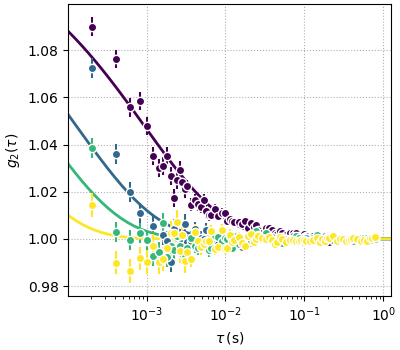

In [ ]:
fig, ax = plt.subplots(figsize=(4,3.5), constrained_layout=True)

g0.plot_g2(nq=np.arange(1,5), dofit=1, doplot='data_fit',
           fix={'beta': 0.13},
           init={'t0': (3e-3, 0, 1),
                 'a': (.7, 0, 3),
                 'g0': (1, 0, 2),
                 #'beta': (.06, 0, 1)
                }, 
           fitglobal=['g0', 'a'], 
           cmap='viridis',ax=ax)
ax.grid(ls=':')
#ax.set_ylim(.9, 2.5)

In [ ]:
g0.pars[0]

,q,t0,dt0,a,da,g0,dg0,b0,db0,beta,dbeta,chisqr,redchi,bic,aic
0,0.045,0.004843,0.000209,1.000053,0.000077,0.422382,0.015318,0.13,0.0,0.13,0.0,559.017689,1.780311,213.125165,190.515239
1,0.080,0.000664,0.000085,1.000053,0.000077,0.422382,0.015318,0.13,0.0,0.13,0.0,559.017689,1.780311,213.125165,190.515239
2,0.115,0.000232,0.000057,1.000053,0.000077,0.422382,0.015318,0.13,0.0,0.13,0.0,559.017689,1.780311,213.125165,190.515239
3,0.150,0.000056,0.000056,1.000053,0.000077,0.422382,0.015318,0.13,0.0,0.13,0.0,559.017689,1.780311,213.125165,190.515239


### attenuated

In [ ]:
g1 = G2(d)
g1.get_g2(ind1, merge='merge')

Merged g2 functions:  [0.0004] (exposure times)
                      [147] (number of correlation functions)
                      [735000] (total number of images)


In [ ]:
g1.reset_rescaled()
g1.rescale(interval=(1, -10))

Fit successful: False


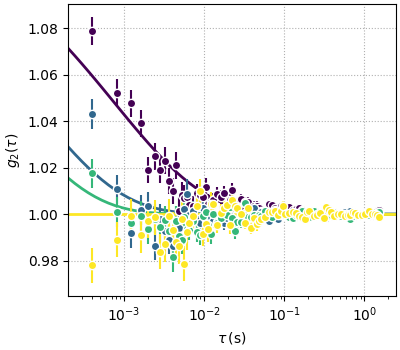

In [ ]:
fig, ax = plt.subplots(figsize=(4,3.5), constrained_layout=True)

g1.plot_g2(nq=np.arange(1,5), dofit=1, doplot='data_fit',
           fix={'beta': 0.13},
           init={'t0': (3e-3, 0, 1),
                 'a': (.7, 0, 3),
                 'g0': (1, 0, 2),
                 #'beta': (.06, 0, 1)
                }, 
           fitglobal=['g0', 'a'], 
           cmap='viridis',ax=ax)
ax.grid(ls=':')
#ax.set_ylim(.9, 2.5)

## Comparison

Fit successful: True
Fit successful: True


Text(0.5, 1.0, 'Q=0.115 $\\mathrm{nm}^{-1}$')

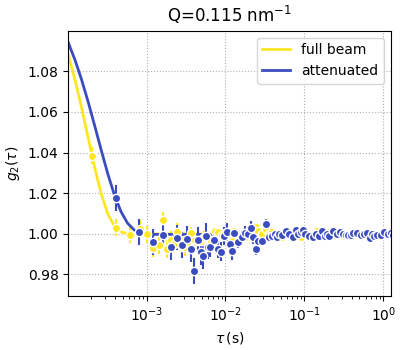

In [ ]:
fig, a1 = plt.subplots(1,1,figsize=(4,3.5), constrained_layout=True)

qmin, qmax = 3, 4
g0.plot_g2(nq=np.arange(qmin,qmax), dofit=1, doplot='data_fit',
           cmap='viridis_r',ax=a1)
g1.plot_g2(nq=np.arange(qmin,qmax), dofit=1, doplot='data_fit',
           cmap='coolwarm_r',ax=a1)
a1.grid(ls=':')
a1.legend(['full beam', 'attenuated'])
a1.set_title(f'Q={d.setup.qv[qmin]:.3f} $\mathrm{{nm}}^{{-1}}$')
#a1.set_ylim(.5, 2.5)

## TTC

In [ ]:
ttc0 = G2(d)
ttc0.get_twotime(ind0, twotime_par=1)

In [ ]:
ttc1 = G2(d)
ttc1.get_twotime(ind1, twotime_par=1)

In [ ]:
tmp = d.get_item(ind0[0])#['twotime_xy'].keys()
ttcxy = tmp['twotime_xy'] # shape (5000,)
qval = tmp['qv']
del tmp

In [ ]:
#ttc0.plot_twotime(ind, twotime_par=1,interpolation='gaussian', clim=[1, 1.15])# ,norm=LogNorm()

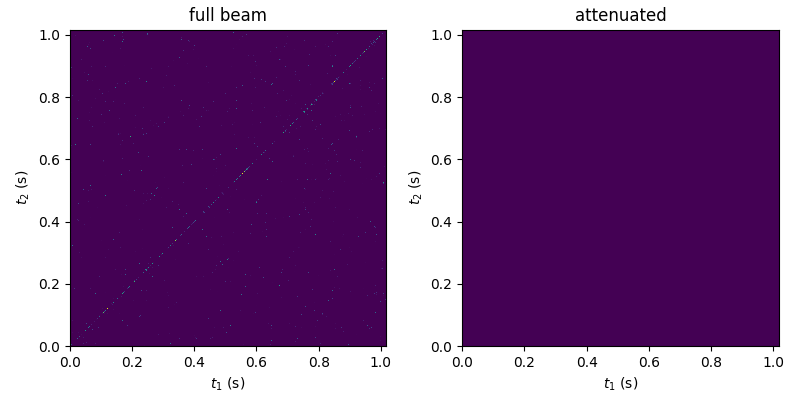

In [ ]:
ttc_0 = ttc0.twotime
ttc_1 = ttc1.twotime

fig, (a1,a2) = plt.subplots(1,2,figsize=(8,4))
im1=a1.imshow(ttc_0,origin='lower',extent=[ttcxy[0], ttcxy[-1]]*2, vmax=1.05,vmin=1) # norm=LogNorm()
im2=a2.imshow(ttc_1, origin='lower',extent=[ttcxy[0], ttcxy[-1]]*2, vmax=1.001,vmin=.99)

a1.set_xlabel('$t_1$ (s)')
a1.set_ylabel('$t_2$ (s)')
a2.set_xlabel('$t_1$ (s)')
a2.set_ylabel('$t_2$ (s)')
a1.set_title('full beam')
a2.set_title('attenuated')
#cbar = colorbar()
#fig.colorbar(im1, cax=a1)
#colorbar()
#a1.set_title(f'Q={qval[1]:.3f} $\mathrm{{nm}}^{{-1}}$')
#a2.set_title(f'Q={qval[2]:.3f} $\mathrm{{nm}}^{{-1}}$')
plt.tight_layout()

# other stuff

In [ ]:
txt

'$D = 272737449771.07 ± 50055991997.19\\,(\\mathrm{\\mu m\\,s^{-1}})$'

<ErrorbarContainer object of 3 artists>

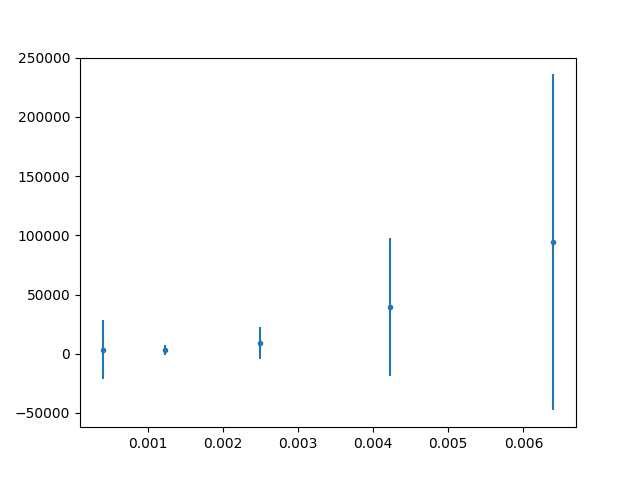

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
p = g2.pars[0]
ax.errorbar(p['q']**2, 1/p['t0'], yerr=1/p['t0']**2*p['dt0'], fmt='.')

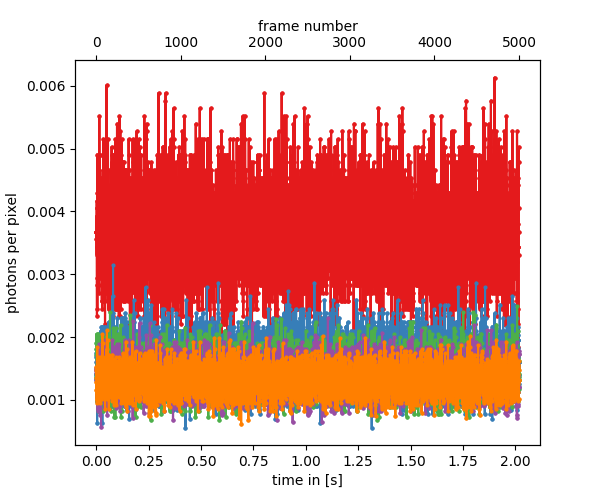

In [ ]:
g2.plot_trace(ind[0])

In [ ]:
g2.pars[0]

,q,t0,dt0,a,da,g0,dg0,beta,dbeta,b0,db0,chisqr,redchi,bic,aic
0,0.020,0.000277,0.001893,0.995785,0.093209,0.197839,0.036936,1.0,0.187998,1.0,0.187998,274.365488,0.707128,-78.903799,-126.801373
1,0.035,0.000350,0.000513,1.000155,0.001016,0.197839,0.036936,1.0,0.187998,1.0,0.187998,274.365488,0.707128,-78.903799,-126.801373
2,0.050,0.000109,0.000160,1.000055,0.000180,0.197839,0.036936,1.0,0.187998,1.0,0.187998,274.365488,0.707128,-78.903799,-126.801373
3,0.065,0.000025,0.000037,1.000385,0.000141,0.197839,0.036936,1.0,0.187998,1.0,0.187998,274.365488,0.707128,-78.903799,-126.801373
4,0.080,0.000011,0.000016,0.999915,0.000126,0.197839,0.036936,1.0,0.187998,1.0,0.187998,274.365488,0.707128,-78.903799,-126.801373


# Other stuff

In [ ]:
traces = []
for index in xana.db.index:
    traces.append(xana.get_item(index)['trace'][:,1].mean())
valid = np.array(traces) < .01
plt.figure()
plt.hist(traces, range=(0,.01))

(array([  0., 132.,   8.,   2.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
        0.009, 0.01 ]),
 <BarContainer object of 10 artists>)

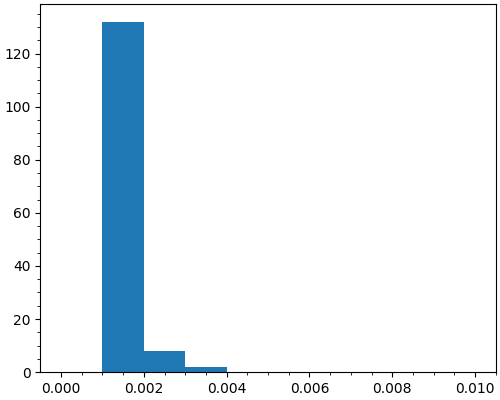

<ErrorbarContainer object of 3 artists>

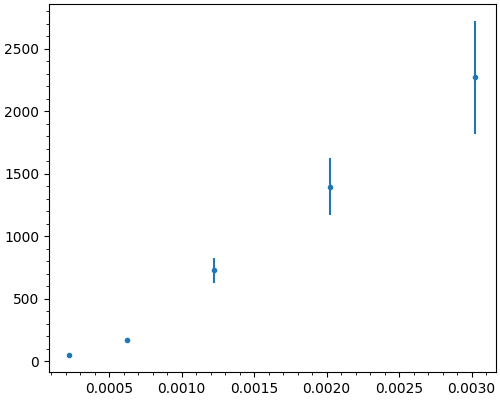

In [ ]:
fig, ax = plt.subplots()
p = g2.pars[0]
ax.errorbar(p['q']**2, 1/p['t0'], yerr=1/p['t0']**2*p['dt0'], fmt='.')


/home/esrf/mario1c/Xana/Xana/Decorators.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(*x, figsize=y)


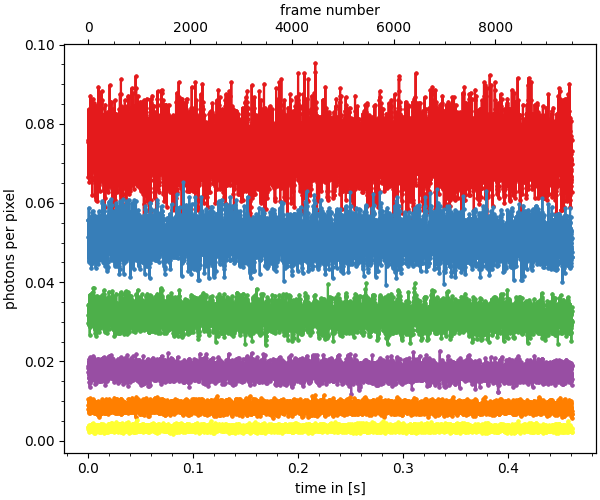

In [ ]:
g2.plot_trace(5)

**SAXS**

In [ ]:
from Xana.SaxsAna import Soq

In [ ]:
ind = xana.db['analysis'] == 'saxs'
ind = xana.db[ind].index.values

In [ ]:
len(ind)

0

In [ ]:
soq = Soq(xana)

/home/esrf/mario1c/Xana/Xana/SaxsAna/Soq.py:170: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout(rect=[0, 0, 0.98, 1])


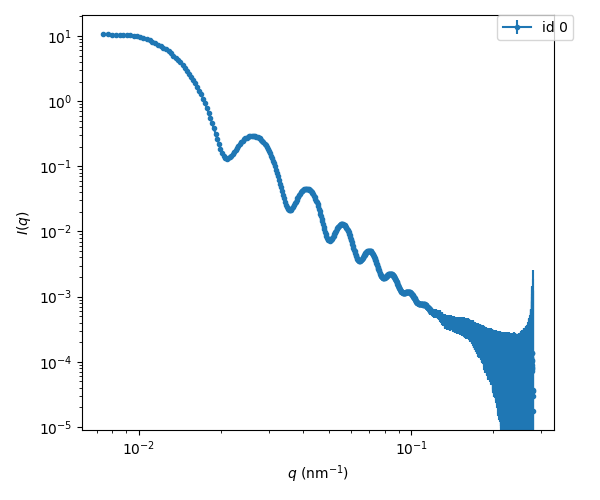

In [ ]:
soq.plot_soq(ind[0],)